# Introduction

MiniML is a personally customized set of functions designed for quick and easy testing of different machine learning models built mainly on the `scikit-learn` library. It includes one-function comparison of different model performance as well as automated grid search functionality. A model explainer via the `SHAP` library is also included for basic model interpretation and further analysis.

This notebook includes functions for classification models and uses a preloaded `scikit-learn` dataset to display sample output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_breast_cancer
import shap

import warnings
import os
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [2]:
data = load_breast_cancer()
X = data["data"]
y = data["target"]
feature_names = data["feature_names"]

df = pd.DataFrame(data=X, columns=feature_names)
df['target'] = y

In [3]:
# path = os.path.abspath(r'C:\Users\Armand\Documents\AIM_Documents\Courses\Term 3\DL\Session 2\UPCAT_DATA2.xlsx')
# df = pd.read_excel(path)
# df = df.dropna()
# df.head()

In [4]:
# df['target']

# Data Cleaning

In [5]:
from sklearn.impute import SimpleImputer as SI

def my_imputer(df, mean=[], median=[], most_frequent=[], fv=np.nan):
    """
    Imputes missing values in the given list of columns
    
    Note: you may have to perform the transformation separately for
    different columns.
    
    Parameters
    ----------
    df : dataframe
    
    mean : list
        list of columns
    
    median : list
        list of columns
        
    most_frequent : list
        list of columns
        
    strategy : str
        impute values according to these:
            mean (default)
            median
            most_frequent : use this for categorical
    """
    if mean != []:
        for col_name in mean:
            imr = SI(strategy='mean', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    
    if median != []:
        for col_name in median:
            imr = SI(strategy='median', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    if most_frequent != []:    
        for col_name in most_frequent:
            imr = SI(strategy='most_frequent', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    
    return df

def replace_trash(df, col, trash):
    """
    Replaces trash values (not nan) with the most frequent value
    in the column.
    
    Parameters
    ----------
    df : dataframe
    
    col : str
        column name of column with trash values
        
    trash : str, int
        whatever it is you want to replace
    """
    fill = df[col].value_counts().index[0]
    df[col].replace(trash, fill)
    df[col] = df[col].replace(trash, fill)
    
    return df

# Data Prep

In [6]:
def split_scale(df, target, split_ratio=0.25, random_state=0, stratify=False,
               scaler=None):
    num_data = df.select_dtypes(include=['int64', 'float64', 'int32'])
    df_targ = num_data[target]
    df_feats = num_data.drop(target, axis=1)
    
    if stratify:
        stratify=df
    else:
        stratify=None

    X_train, X_test, y_train, y_test = train_test_split(df_feats, df_targ, 
                                                    test_size=split_ratio, 
                                                    random_state=random_state, 
                                                    stratify=stratify)
    if scaler == 'minmax':
        scaler_obj = MinMaxScaler()
    elif scaler == 'robust':
        scaler_obj = RobustScaler()
    elif scaler == 'standard':
        scaler_obj = StandardScaler()
    elif scaler == 'norm':
        scaler_obj = Normalizer(norm=lp)
    else:
        pass
    
    if scaler is not None:
        X_train = scaler_obj.fit_transform(X_train)
        X_test = scaler_obj.fit_transform(X_test)
    else:
        pass
    
    model_data = {'X_train': X_train, 
                  'X_test': X_test, 
                  'y_train':y_train, 
                  'y_test':y_test, 
                  'features':df_feats.columns}
    
    return model_data

In [7]:
model_data = split_scale(df, target='target', split_ratio=0.30, random_state=0,
           stratify=False, scaler=None)

# ML Models: Looped

## Classifiers



In [8]:
def quick_test(df, target_col, ratio=0.25, r_state=0, scaler='None'):
    """
    Displays a variety of machine learning models and their respective
    training and test scores. Feature importance is also displayed if 
    applicable.
    """
    names = ["Logistic Regression",
             "Nearest Neighbors", 
             "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Gradient Boosting", 
             "AdaBoost"]

    classifiers = [
        LogisticRegression(),
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        GradientBoostingClassifier(),
        AdaBoostClassifier()]

    model_data = split_scale(df, target_col, split_ratio=ratio, random_state=r_state,
               stratify=False, scaler=None)

    X_train = model_data['X_train']
    X_test = model_data['X_test']
    y_train = model_data['y_train']
    y_test = model_data['y_test']
    
    training_acc = []
    test_acc = []
    top_predictor = []
    
    for ml in classifiers:
        model = ml
        mod_obj = model.fit(X_train, y_train)

        training_acc.append(model.score(X_train, y_train))
        test_acc.append(model.score(X_test, y_test))
        
        try:
            feature_importance = mod_obj.feature_importances_
            # feature_importance[np.argsort(feature_importance)[-1]]
            top_predictor.append(
                model_data['X_train'].columns[np.argsort(feature_importance)[-1]])
        except:
            top_predictor.append('N/A')
        
    df_out = pd.DataFrame({'Model': names, 'Train Acc': training_acc, 
                           "Test Acc": test_acc, 'Top Predictor': top_predictor})
    return df_out

In [9]:
# quick_test(df, 'target')

In [10]:
params_gs = {
    'KNN':{'n_neighbors': [1,3, 5, 7, 9, 11, 13, 15]},
    'LogisticRegression': {'C': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'LogisticRegression L2': {'C': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'SVM L1': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000]},
    'SVM L2': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000]},
    'SVC RBF': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000], 
               'gamma': [1e-2,0.1, 1, 2, 3, 5, 10,
                        15, 20, 100, 500, 1000 ]},
    'SVC Poly': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000], 
                 'degree': [3],
                 'coef0': [0,5,10, 100]},
    'Random Forest': {'n_estimators': [100, 500, 1000], 
                      'max_features' : [None, 3, 5, 'auto'],
                      'max_depth' : list(range(3, 10))#+[None],
                     },
    'Decision Tree':{'max_depth' : range(3, 5)},
    'GBM': {'n_estimators': [100, 500, 1000], 
                      'max_features' :  [None, 3, 5, 'auto'],
                      'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
                      'max_depth' : list(range(3, 10))#+[None],
                     },
    'Ridge': {'alpha': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'Lasso': {'alpha': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'Ada Boost': {'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
                  'n_estimators': [100, 500, 1000]},
    'XGBoost': {'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
               'max_depth' : list(range(3, 10)),
               'n_estimators': [100, 500, 1000]}
}

# Grid Search

In [11]:
def grid_search_all(df, target_col, ratio=0.30, r_state=0, scaler='None'):
    """
    Displays a variety of machine learning models and their respective
    training and test scores. Feature importance is also displayed if 
    applicable.
    
    Uses GridSearch to find the best combination of hyper parameters
    listed in params_gs.
    
    This may take a while to run.
    """
    names = ["LogisticRegression",
             "KNN", "SVM L1", "SVC RBF", 
             "Decision Tree", "Random Forest", "GBM", 
             "Ada Boost"]

    model_list = [
        LogisticRegression(),
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        GradientBoostingClassifier(),
        AdaBoostClassifier()]
    
    model_iter = list(zip(names, model_list))

    model_data = split_scale(df, target_col, split_ratio=ratio, random_state=r_state,
               stratify=False, scaler=None)

    X_train = model_data['X_train']
    X_test = model_data['X_test']
    y_train = model_data['y_train']
    y_test = model_data['y_test']
    
    training_acc = []
    test_acc = []
    top_predictor = []
    params = []
    
    for ml in model_iter:
        print(ml[0])
        model = ml[1]
        model.fit(X_train, y_train)
        model_out = GridSearchCV(model, param_grid = params_gs[ml[0]], iid=False)
        mod_obj = model_out.fit(X_train, y_train)
        
        
        training_acc.append(mod_obj.score(X_train, y_train))
        test_acc.append(mod_obj.score(X_test, y_test))
        params.append(mod_obj.best_params_)
        
        try:
            feature_importance = mod_obj.best_estimator_.feature_importances_
            # feature_importance[np.argsort(feature_importance)[-1]]
            top_predictor.append(
                model_data['X_train'].columns[np.argsort(feature_importance)[-1]])
        except:
            top_predictor.append('N/A')
        
    df_out = pd.DataFrame({'Model': names, 'Train Acc': training_acc, 
                           "Test Acc": test_acc, 'Top Predictor': top_predictor,
                          "Best Params": params})
    return df_out

In [12]:
grid_search_all(df, 'target')

LogisticRegression
KNN
SVM L1
SVC RBF
Decision Tree
Random Forest
GBM
Ada Boost


,Model,Train Acc,Test Acc,Top Predictor,Best Params
0,LogisticRegression,0.949749,0.953216,N/A,{'C': 10}
1,KNN,0.934673,0.964912,N/A,{'n_neighbors': 11}
2,SVM L1,0.962312,0.941520,N/A,{'C': 0.1}
3,SVC RBF,1.000000,0.631579,N/A,"{'C': 10, 'gamma': 0.01}"
4,Decision Tree,0.967337,0.935673,worst concave points,{'max_depth': 3}
5,Random Forest,1.000000,0.970760,worst concave points,"{'max_depth': 8, 'max_features': 'auto', 'n_es..."
6,GBM,1.000000,0.982456,perimeter error,"{'learning_rate': 0.4, 'max_depth': 5, 'max_fe..."
7,Ada Boost,1.000000,1.000000,worst texture,"{'learning_rate': 1.9000000000000004, 'n_estim..."


# Model Scratch

In [13]:
model_data = split_scale(df, 'target', split_ratio=0.30, random_state=0,
           stratify=False, scaler=None)

model = RandomForestClassifier()
model.fit(model_data['X_train'], model_data['y_train'])

RandomForestClassifier()

In [14]:
model_out = GridSearchCV(model, param_grid = params_gs['Random Forest'], 
                         scoring = 'r2')

In [15]:
out = model_out.fit(model_data['X_train'], model_data['y_train'])

In [16]:
out.best_params_

{'max_depth': 9, 'max_features': 3, 'n_estimators': 500}

# Confusion Matrix

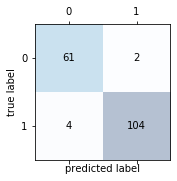

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.98      0.96      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171



In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = out.predict(model_data['X_test'])
confmat = confusion_matrix(y_true=model_data['y_test'], y_pred=y_pred)

y_pred = out.predict(model_data['X_test'])
confmat = confusion_matrix(y_true=model_data['y_test'], y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print(classification_report(model_data['y_test'], y_pred))

# SHAP

In [18]:
shap_values = shap.KernelExplainer(model.predict, 
                                   model_data['X_train']).shap_values(model_data['X_train'])

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [19]:
def explain_model(df_shap, df, simplify=False):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
#     display(shap_v)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0,
                               'red', 'blue')
    
    if simplify:
        # Plot bar
        shap_abs = np.abs(shap_v)
        k=pd.DataFrame(shap_abs.mean()).reset_index()
        k.columns = ['Variable','SHAP_abs']
        k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
        k2 = k2.sort_values(by='SHAP_abs',ascending = True)
        colorlist = k2['Sign']
        ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,6),legend=False)
        ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    else:
        # Plot Summary
        shap.summary_plot(shap_values, model_data['X_train'])

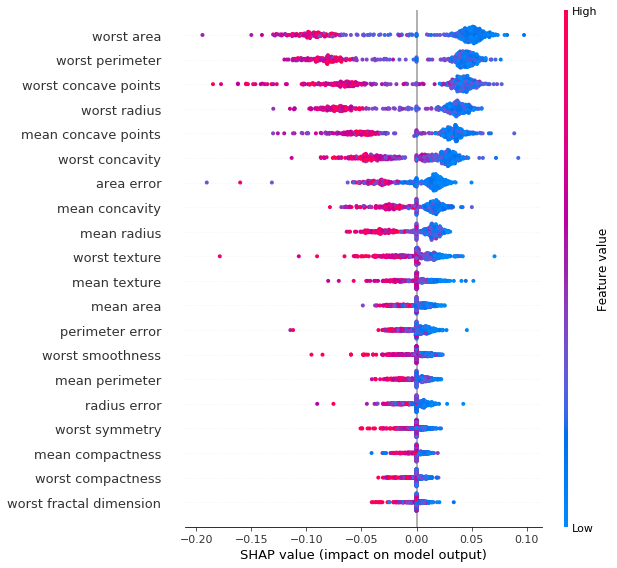

In [20]:
explain_model(shap_values, model_data['X_train'], False)

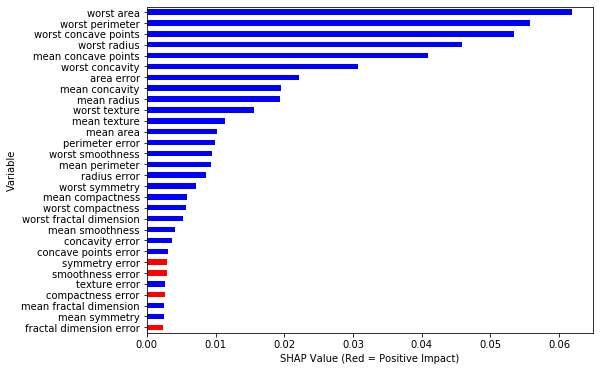

In [21]:
explain_model(shap_values, model_data['X_train'], True)